Data Loaded
=== Stacking Model (LightGBM + XGBoost) Performance ===
Accuracy:  0.988
Precision: 0.206
Recall:    0.762
F1 Score:  0.324
ROC AUC:   0.973


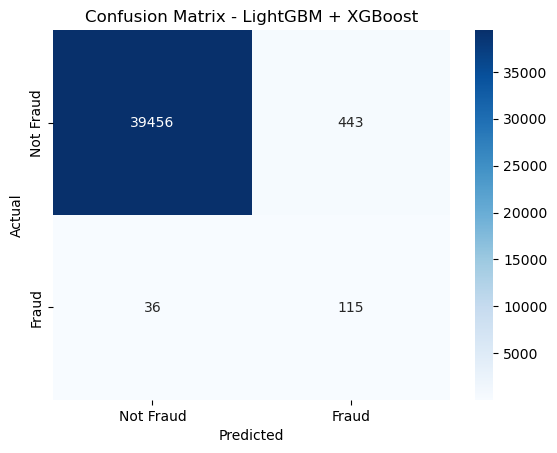

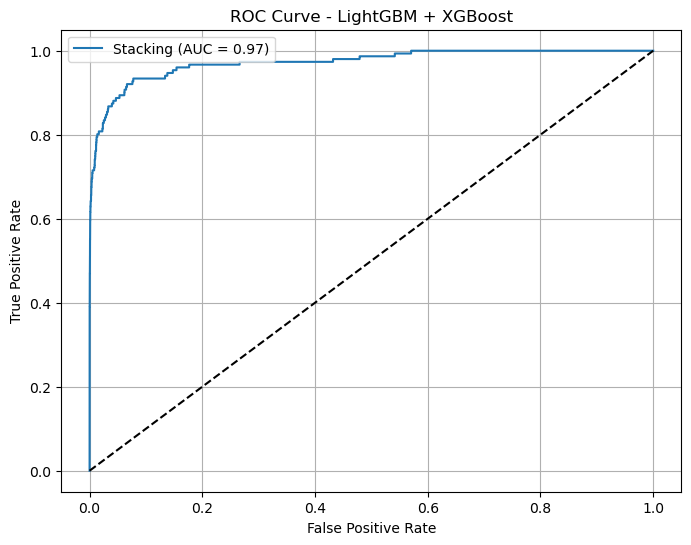

In [3]:
# STEP 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 2: Load and Prepare Data
users = pd.read_csv(r"C:\Users\ND.COM\Downloads\users.csv")           
transactions = pd.read_csv(r"C:\Users\ND.COM\Downloads\transactions.csv")  
fraudsters = pd.read_csv(r"C:\Users\ND.COM\Downloads\fraudsters.csv")  
print("Data Loaded")

fraud_ids = set(fraudsters['USER_ID'])

txn_grp = transactions.groupby('USER_ID')
user_features = txn_grp.agg(
    trans_count=('ID', 'count'),
    total_amount=('AMOUNT_GBP', 'sum'),
    avg_amount=('AMOUNT_GBP', 'mean'),
    failed_count=('STATE', lambda x: (x == 'FAILED').sum()),
    currency_count=('CURRENCY', pd.Series.nunique)
).reset_index()
user_features['fail_rate'] = user_features['failed_count'] / user_features['trans_count']

type_dummies = pd.get_dummies(transactions['TYPE'])
type_counts = transactions[['USER_ID']].join(type_dummies).groupby('USER_ID').sum().reset_index()

features = pd.merge(user_features, type_counts, on='USER_ID', how='left')
features = pd.merge(features, users, left_on='USER_ID', right_on='ID', how='left')
today = datetime(2025, 5, 15)
features['CREATED_DATE'] = pd.to_datetime(features['CREATED_DATE'], errors='coerce')
features['BIRTH_DATE'] = pd.to_datetime(features['BIRTH_DATE'], errors='coerce')
features['account_age_days'] = (today - features['CREATED_DATE']).dt.days
features['user_age'] = ((today - features['BIRTH_DATE']).dt.days / 365).astype(int)
features.drop(['CREATED_DATE', 'BIRTH_DATE', 'ID'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['COUNTRY'], prefix='Country')
features['is_fraud'] = features['USER_ID'].isin(fraud_ids).astype(int)
features.drop('USER_ID', axis=1, inplace=True)

# STEP 3: Train-Test Split and Scaling
X = features.drop('is_fraud', axis=1)
y = features['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# STEP 4: Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# STEP 5: Define Base Models with Adjusted Class Weights
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train), use_label_encoder=False, eval_metric='logloss', random_state=42)

# STEP 6: Define Meta Model
meta_model = LogisticRegression(solver='lbfgs', max_iter=1000)

# STEP 7: Create and Train Stacking Classifier
stacking_model = StackingClassifier(
    estimators=[('lgb', lgb), ('xgb', xgb)],
    final_estimator=meta_model,
    passthrough=False,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_scaled, y_train_resampled)

# STEP 8: Evaluation with Adjusted Threshold
y_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]
threshold = 0.3  # Adjust as needed
y_pred = (y_proba >= threshold).astype(int)

print("=== Stacking Model (LightGBM + XGBoost) Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")

# STEP 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix - LightGBM + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 10: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Stacking (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM + XGBoost")
plt.legend()
plt.grid(True)
plt.show()